# Chapter 7 Lab 8

## Goal
In this lab, we will continue to use the DoTalicious data set from previous labs. Using a Decision Tree (DT) for classification, we will attempt to predict a player's SkillLevel. If you remember, the raw data represents skill level with numbers between 0 and 3 with 0 being Novice and 3 being Expert. We would expect a player's SkillLevel to be a reflection of their other stats such as Kills and Deaths.

Scikit-learn has a DecisionTreeClassifier package that we will use. We will use RepeatKFold and GridSearchCV again for this exersice to tune the complexity parameter.

## Preparation

Load the required packages below.

In [23]:
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, cohen_kappa_score, classification_report, precision_recall_fscore_support, make_scorer
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
from io import StringIO

import warnings
warnings.filterwarnings('ignore')


## Step 1: Data Pre-processing

Let's read in the data and take a quick look at it.

In [3]:
dota_df1 = pd.read_csv('DoTalicious_cleaned1000players.csv')
dota_df1.drop(['PlayerID'], axis=1, inplace=True)
dota_df1.head()

,GamesPlayed,GamesWon,GamesLeft,Ditches,Points,SkillLevel,Kills,KillsPerMin,Deaths,Assists,CreepsKilled,CreepsDenied,NeutralsKilled,TowersDestroyed,RaxsDestroyed,TotalTime
0,447,248,6,6,1111.360,1,2271,0.12,1889,4201,38736,3058,3456,355,151,1116780
1,66,39,0,0,989.882,1,373,0.13,450,745,4484,518,455,49,23,169800
2,3,0,0,0,1000.000,0,11,0.11,28,18,186,10,7,0,0,6180
3,100,59,5,1,1228.460,1,1079,0.26,448,934,13943,1885,1417,132,36,250200
4,1,1,0,0,1020.000,0,9,0.28,2,10,38,8,3,0,0,1944


In [4]:
dota_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 868 entries, 0 to 867
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GamesPlayed       868 non-null    int64  
 1   GamesWon          868 non-null    int64  
 2   GamesLeft         868 non-null    int64  
 3   Ditches           868 non-null    int64  
 4   Points            868 non-null    float64
 5   SkillLevel        868 non-null    object 
 6   Kills             868 non-null    int64  
 7   KillsPerMin       868 non-null    float64
 8    Deaths           868 non-null    int64  
 9   Assists           868 non-null    int64  
 10  CreepsKilled      868 non-null    int64  
 11  CreepsDenied      868 non-null    int64  
 12   NeutralsKilled   868 non-null    int64  
 13   TowersDestroyed  868 non-null    int64  
 14   RaxsDestroyed    868 non-null    int64  
 15   TotalTime        868 non-null    object 
dtypes: float64(2), int64(12), object(2)
memory u

In [5]:
dota_df1 = dota_df1.rename(columns=lambda x: x.strip())
dota_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 868 entries, 0 to 867
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   GamesPlayed      868 non-null    int64  
 1   GamesWon         868 non-null    int64  
 2   GamesLeft        868 non-null    int64  
 3   Ditches          868 non-null    int64  
 4   Points           868 non-null    float64
 5   SkillLevel       868 non-null    object 
 6   Kills            868 non-null    int64  
 7   KillsPerMin      868 non-null    float64
 8   Deaths           868 non-null    int64  
 9   Assists          868 non-null    int64  
 10  CreepsKilled     868 non-null    int64  
 11  CreepsDenied     868 non-null    int64  
 12  NeutralsKilled   868 non-null    int64  
 13  TowersDestroyed  868 non-null    int64  
 14  RaxsDestroyed    868 non-null    int64  
 15  TotalTime        868 non-null    object 
dtypes: float64(2), int64(12), object(2)
memory usage: 108.6+ KB


Notice that we will need to change some data types.

In [6]:
dota_df1['TotalTime'] = pd.to_numeric(dota_df1['TotalTime'], errors='coerce')

We'll make a quick fix to an odd value in SkillLevel too. Here, we'll remove the row.

In [7]:
dota_df1.loc[dota_df1['SkillLevel'] ==' SkillLevelNull', 'SkillLevel'] = '1'

Lastly, let's work on the SkillLevel column! We need to change it to categorical.

In [8]:
dota_df1['SkillLevel'] = pd.Series(dota_df1['SkillLevel'].astype('category'))
dota_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 868 entries, 0 to 867
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   GamesPlayed      868 non-null    int64   
 1   GamesWon         868 non-null    int64   
 2   GamesLeft        868 non-null    int64   
 3   Ditches          868 non-null    int64   
 4   Points           868 non-null    float64 
 5   SkillLevel       868 non-null    category
 6   Kills            868 non-null    int64   
 7   KillsPerMin      868 non-null    float64 
 8   Deaths           868 non-null    int64   
 9   Assists          868 non-null    int64   
 10  CreepsKilled     868 non-null    int64   
 11  CreepsDenied     868 non-null    int64   
 12  NeutralsKilled   868 non-null    int64   
 13  TowersDestroyed  868 non-null    int64   
 14  RaxsDestroyed    868 non-null    int64   
 15  TotalTime        867 non-null    float64 
dtypes: category(1), float64(3), int64(12)
memory

Next, let's check for null values and remove those.

In [9]:
dota_df1.isna().sum().sum()

1

In [10]:
dota_df1[dota_df1.isnull().any(axis=1)]

,GamesPlayed,GamesWon,GamesLeft,Ditches,Points,SkillLevel,Kills,KillsPerMin,Deaths,Assists,CreepsKilled,CreepsDenied,NeutralsKilled,TowersDestroyed,RaxsDestroyed,TotalTime
517,0,0,0,0,1000.0,0,0,0.0,0,0,0,0,0,0,0,NaN


In [11]:
dota_df1.drop([517], inplace=True)

In [12]:
dota_df1.isna().sum().sum()

0

## Step 2: Set up training and testing set

The first step is to split the data into two pieces of two parts each: first into X, y for predictors and target respectively and then train (X,y) and test (X,y).

As discussed in Lab 2, we will also standardize the data after splitting it.

Keep in mind, as also mentioned in Lab 2, there is a mild debate about whether or not you should also scale the y (target) data because in doing so, you lose interpretability but in not doing so you do NOT usually lose any model quality.

Here, we will only standardize the independent variables (aka predictors or X).

In [13]:
y = dota_df1['SkillLevel']
X = dota_df1.drop(['SkillLevel'], axis=1, inplace=False)

We set 'test_size' to 0.25, which means the training data size will be 75% of the original data sets X and y.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

Lastly, we'll standardize the data.

## Step 3: Apply the SVM Model

In [21]:
#define a new scorer
def kappa_scorer(est, X, y):
    y_pred = est.predict(X)
    kappa = cohen_kappa_score(y, y_pred)
    return kappa

In [36]:
#Setup and configure settings for Repeated k-Fold CV (k-folds=10, repeats=10)
rcv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=101)

#define model
dtc = DecisionTreeClassifier()
scoring = {'Accuracy':'accuracy', 'Kappa':make_scorer(cohen_kappa_score)}
alphas = list(np.arange(0.1, 1.0, 0.04))
params = {'ccp_alpha':alphas}

#create model, perform Repeated CV and evaluate model
scores = GridSearchCV(dtc, params, scoring=scoring, cv=rcv, refit='Accuracy', n_jobs=-1)
scores.fit(X_train, y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=101),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0.1, 0.14, 0.18000000000000002,
                                       0.22000000000000003, 0.26,
                                       0.30000000000000004, 0.3400000000000001,
                                       0.38, 0.42000000000000004,
                                       0.4600000000000001, 0.5000000000000001,
                                       0.54, 0.5800000000000001,
                                       0.6200000000000001, 0.66,
                                       0.7000000000000001, 0.7400000000000001,
                                       0.7800000000000001, 0.8200000000000002,
                                       0.8600000000000001, 0.9000000000000001,
                                       0.9400000000000002,
                                       0.9800000000000001]},
             refit='Accuracy',
             scoring={'Accuracy': 'accuracy',
                      'Kappa': make_scorer(cohen_kappa_score)})

In [39]:
cv_df = pd.DataFrame(scores.cv_results_)
cv_res_df = pd.DataFrame(cv_df[['param_ccp_alpha', 'mean_test_Accuracy', 'mean_test_Kappa']])
cv_res_df.rename(columns = {'param_ccp_alpha' : 'Complexity', 'mean_test_Accuracy' : 'Accuracy', 'mean_test_Kappa' : 'Kappa'}, inplace=True)
cv_res_df

,Complexity,Accuracy,Kappa
0,0.1,0.909231,0.822002
1,0.14,0.909231,0.822002
2,0.18,0.909231,0.822002
3,0.22,0.909231,0.822002
4,0.26,0.909231,0.822002
5,0.3,0.909231,0.822002
6,0.34,0.909231,0.822002
7,0.38,0.516923,0.000000
8,0.42,0.516923,0.000000
9,0.46,0.516923,0.000000


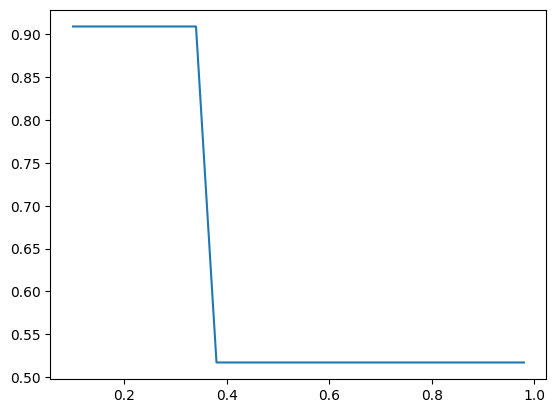

In [40]:
plt.plot(cv_res_df['Complexity'], cv_res_df['Accuracy']);

From the above, we will pick a ccp_alpha of 0.34.

The most common way to evaluate classification visually is with a confusion matrix. Bascially, if you predict skill level 0 and the original 'true' label was 0, then you have a true positive. Depending on your intent, this might be what you're hoping to maximize.

You will explore the types of metrics in Chapter 8 in more detail.

Below is a confusion matrix.

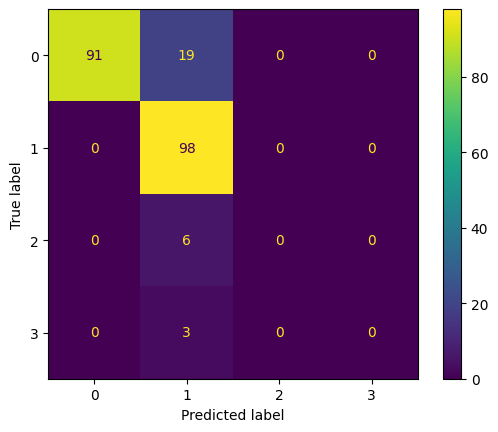

In [48]:
final_model = scores.best_estimator_
dtc_pred = final_model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, dtc_pred)
plt.show()

In R, the output is much more detailed. Python produces a report that is more focused on the three metrics you will use most often. Again, you will see these in more detail in the next chapter.

'Support' is simply the total number of observations for each particular class. So, for the first line, 'class 0' there are 110 observations.

In [49]:
target_names = ['class 0', 'class 1', 'class 2', 'class 3']
print(classification_report(y_test, dtc_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       1.00      0.83      0.91       110
     class 1       0.78      1.00      0.88        98
     class 2       0.00      0.00      0.00         6
     class 3       0.00      0.00      0.00         3

    accuracy                           0.87       217
   macro avg       0.44      0.46      0.45       217
weighted avg       0.86      0.87      0.85       217



We can also call up the Kappa separately if we're worried about an imbalance.

In [51]:
cohen_kappa_score(y_test, dtc_pred)

0.7543164449476366

Lastly, R focuses on 'specificity' and 'sensitivity'. These are actually two forms of 'recall'. Recall of a positive class is sensitivity while recall of a negative class is specificity.

The issue is that this works in binary classification only. For present purposes, we can manipulate the predicted data into a binary for each class we have and then call up specificity and sensitivity.

In [52]:
prfs = []
for l in [0,1,2,3]:
    prec,recall,_,_ = precision_recall_fscore_support(np.array(y_test).astype(float)==l, np.array(dtc_pred.astype(float))==l, pos_label=True,average=None)
    prfs.append([recall[1],recall[0]])

pd.DataFrame(prfs, columns = ['sensitivity','specificity']).transpose()

,0,1,2,3
sensitivity,0.827273,1.000000,0.0,0.0
specificity,1.000000,0.764706,1.0,1.0


Relatively, when compared to our other classifiers in this chapter, the DecisionTreeClassifier performs well - it exceeds KNN  - at 84% Accuracy - with a score of 87%!. 

We do continue to see, however, this weak classification of Skill Levels 2 and 3. One reason for this is that the data are insufficient to characterize them.

## Step 4: Visualization

In [70]:
#! pip install graphviz
from sklearn import tree
import graphviz 

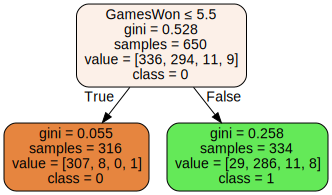

In [71]:
dtc_data = tree.export_graphviz(final_model, out_file=None, feature_names=list(X_train.columns), class_names=['0','1','2','3'], filled=True, rounded=True,
                                special_characters=True) 
graph = graphviz.Source(dtc_data)  
graph

This is a very useful visualization. The first line of the first internal leaf - at the top of the tree -show you the "decision criteria". Here it first split the data into two group by splitting those with less than 5.5 GamesWon from those with greater than 5.5.

Granted, as we noted above, the data seem insufficient for further classification, so that's where the model ends - with two leafs. Clearly, this means that the model only see two groups distinctly.